---

<h2 style="text-align: center;"><b>Свёрточные нейронные сети: CIFAR10</b></h3>

---

В этом ноутбке мы посмотрим, насколько хорошо CNN будут предсказывать классы на более сложном датасете картинок -- CIFAR10. 

**Внимание:** Рассматривается ***задача классификации изображений***.

***Свёрточная нейросеть (Convolutional Neural Network, CNN)*** - это многослойная нейросеть, имеющая в своей архитектуре помимо *полносвязных слоёв* (а иногда их может и не быть) ещё и **свёрточные слои (Conv Layers)** и **pooling-слои (Pool Layers)**.  

Собственно, название такое эти сети получили потому, что в основе их работы лежит операция **свёртки**.

Сразу же стоит сказать, что свёрточные нейросети **были придуманы прежде всего для задач, связанных с изображениями**, следовательно, на вход они тоже "ожидают" изображение.

* Например, вот так выглядит неглубокая свёрточная нейросеть, имеющая такую архитектуру:  
`Input -> Conv 5x5 -> Pool 2x2 -> Conv 5x5 -> Pool 2x2 -> FC -> Output`

<img src="https://camo.githubusercontent.com/269e3903f62eb2c4d13ac4c9ab979510010f8968/68747470733a2f2f7261772e6769746875622e636f6d2f746176677265656e2f6c616e647573655f636c617373696669636174696f6e2f6d61737465722f66696c652f636e6e2e706e673f7261773d74727565" width=800, height=600>  
  
Свёрточные нейросети (простые, есть и намного более продвинутые) почти всегда строятся по следующему правилу:  

`INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*L -> FC`  

то есть:  

1). ***Входной слой***: batch картинок -- тензор размера `(batch_size, H, W, C)` или `(batch_size, C, H, W)`

2). $M$ блоков (M $\ge$ 0) из свёрток и pooling-ов, причём именно в том порядке, как в формуле выше. Все эти $M$ блоков вместе называют ***feature extractor*** свёрточной нейросети, потому что эта часть сети отвечает непосредственно за формирование новых, более сложных признаков поверх тех, которые подаются (то есть, по аналогии с MLP, мы опять же переходим к новому признаковому пространству, однако здесь оно строится сложнее, чем в обычных многослойных сетях, поскольку используется операция свёртки)  

3). $L$ штук FullyConnected-слоёв (с активациями). Эту часть из $L$ FC-слоёв называют ***classificator***, поскольку эти слои отвечают непосредственно за предсказание нужно класса (сейчас рассматривается задача классификации изображений).


<h3 style="text-align: center;"><b>Свёрточная нейросеть на PyTorch</b></h3>

Ешё раз напомним про основные компоненты нейросети:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво **эпох** обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (`weight_decay`, для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

Так как мы сейчас рассматриваем **архитектуру CNN**, то, помимо этих компонент, в свёрточной нейросети можно настроить следующие вещи:  

- (в каждом ConvLayer) **размер фильтров (окна свёртки)** (`kernel_size`)
- (в каждом ConvLayer) **количество фильтров** (`out_channels`)  
- (в каждом ConvLayer) размер **шага окна свёртки (stride)** (`stride`)  
- (в каждом ConvLayer) **тип padding'а** (`padding`)  


- (в каждом PoolLayer) **размер окна pooling'a** (`kernel_size`)  
- (в каждом PoolLayer) **шаг окна pooling'а** (`stride`)  
- (в каждом PoolLayer) **тип pooling'а** (`pool_type`)  
- (в каждом PoolLayer) **тип padding'а** (`padding`)

<h3 style="text-align: center;"><b>CIFAR10</b></h3>

<img src="https://raw.githubusercontent.com/soumith/ex/gh-pages/assets/cifar10.png" width=500, height=400>

**CIFAR10:** это набор из 60k картинок 32х32х3, 50k которых составляют обучающую выборку, и оставшиеся 10k - тестовую. Классов в этом датасете 10: `'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'`.

In [1]:
# !pip install torch torchvision

In [2]:
import torch
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tqdm import tqdm_notebook

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../pytorch_data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../pytorch_data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../pytorch_data\cifar-10-python.tar.gz to ../pytorch_data
Files already downloaded and verified


In [5]:
# trainset.data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [6]:
trainloader.dataset.train_list[0]

['data_batch_1', 'c99cafc152244af753f735de768cd75f']

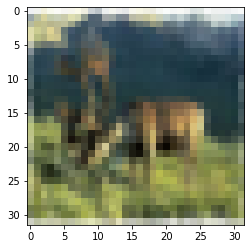

In [7]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=50000)

plt.imshow(trainloader.dataset.data[i]);

Напишем свёрточную нейросеть для предсказания на CIFAR10.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class SimpleConvNet(torch.nn.Module):
    def __init__(self):
        # вызов конструктора класса nn.Module()
        super(SimpleConvNet, self).__init__()
        # feature extractor
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # classificator
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Обучим:

In [10]:
from tqdm import tqdm_notebook

In [11]:
net = SimpleConvNet()

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(3)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # выводим качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/3477602096.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(3)):


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/3477602096.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 2.028
[1,  4000] loss: 1.774
[1,  6000] loss: 1.697
[1,  8000] loss: 1.639
[1, 10000] loss: 1.599
[1, 12000] loss: 1.588


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.535
[2,  4000] loss: 1.515
[2,  6000] loss: 1.501
[2,  8000] loss: 1.478
[2, 10000] loss: 1.470
[2, 12000] loss: 1.433


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.423
[3,  4000] loss: 1.416
[3,  6000] loss: 1.389
[3,  8000] loss: 1.373
[3, 10000] loss: 1.356
[3, 12000] loss: 1.373
Обучение закончено


Посмотрим на accuracy на тестовом датасете:

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 34 %
Accuracy of   car : 63 %
Accuracy of  bird : 24 %
Accuracy of   cat : 32 %
Accuracy of  deer : 35 %
Accuracy of   dog : 47 %
Accuracy of  frog : 74 %
Accuracy of horse : 53 %
Accuracy of  ship : 79 %
Accuracy of truck : 54 %


Проверим работу нейросети визуально (позапускайте ячейку несколько раз):

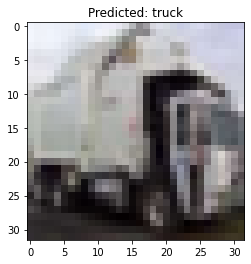

In [13]:
i = np.random.randint(low=0, high=10000)

def visualize_result(index):
    image = testloader.dataset.data[index]
    plt.imshow(image)
    
    image = transform(image)  # не забудем отмасштабировать!
    
    y_pred = net(image.view(1, 3, 32, 32))
    _, predicted = torch.max(y_pred, 1)
    
    plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')

visualize_result(i)

Улучшим свёрточную нейросеть: поэкспериментируем с архитектурой (количество слоёв, порядок слоёв), с гиперпараметрами слоёв (размеры kernel_size, размеры pooling'а, количество kernel'ов в свёрточном слое) и с гиперпараметрами, указанными в "Компоненты нейросети" (см. памятку выше).

In [14]:
class BetterConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора класса nn.Module()
        super(BetterConvNet, self).__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        
        self.fc1 = nn.Linear(3 * 3 * 32, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(self.conv3(F.relu(self.conv2(x))))
#         print(x.shape)
        x = x.view(-1, 3 * 3 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Обучим:

In [15]:
from tqdm import tqdm_notebook

In [16]:
net = BetterConvNet()

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(5)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/4107937569.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(5)):


  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/4107937569.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 1.905
[1,  4000] loss: 1.639
[1,  6000] loss: 1.569
[1,  8000] loss: 1.526
[1, 10000] loss: 1.514
[1, 12000] loss: 1.489


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.408
[2,  4000] loss: 1.425
[2,  6000] loss: 1.393
[2,  8000] loss: 1.387
[2, 10000] loss: 1.375
[2, 12000] loss: 1.346


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.294
[3,  4000] loss: 1.308
[3,  6000] loss: 1.322
[3,  8000] loss: 1.280
[3, 10000] loss: 1.270
[3, 12000] loss: 1.284


  0%|          | 0/12500 [00:00<?, ?it/s]

[4,  2000] loss: 1.226
[4,  4000] loss: 1.242
[4,  6000] loss: 1.233
[4,  8000] loss: 1.210
[4, 10000] loss: 1.234
[4, 12000] loss: 1.225


  0%|          | 0/12500 [00:00<?, ?it/s]

[5,  2000] loss: 1.174
[5,  4000] loss: 1.160
[5,  6000] loss: 1.204
[5,  8000] loss: 1.175
[5, 10000] loss: 1.192
[5, 12000] loss: 1.220
Обучение закончено


In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 80 %
Accuracy of  bird : 29 %
Accuracy of   cat : 52 %
Accuracy of  deer : 37 %
Accuracy of   dog : 22 %
Accuracy of  frog : 72 %
Accuracy of horse : 76 %
Accuracy of  ship : 58 %
Accuracy of truck : 55 %


Если качество ~70% в среднем, то текущая нейросеть вполне неплоха (однако на этом датасете известны архитектуры, дающие 95+% качества).

Посмотрим визуально на работу нейросети:

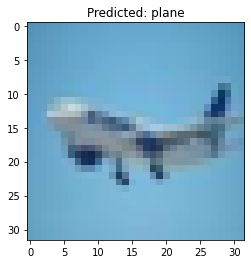

In [18]:
i = np.random.randint(low=0, high=10000)

def visualize_result(index):
    image = testloader.dataset.data[index]
    plt.imshow(image)
    
    image = transform(image)  # не забудем отмасштабировать!
    
    y_pred = net(image.view(1, 3, 32, 32))
    _, predicted = torch.max(y_pred, 1)
    
    plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')

visualize_result(i)

Попробуем обучить ещё более сильную нейросеть:

In [19]:
class StrongConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора класса nn.Module()
        super(StrongConvNet, self).__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout = nn.Dropout(p=0.2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(32)
        
        self.fc1 = nn.Linear(4 * 4 * 32, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool(x)
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))
#         print(x.shape)
        x = x.view(-1, 4 * 4 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Обучим:

In [20]:
from tqdm import tqdm_notebook

In [21]:
from torch.optim import lr_scheduler

In [22]:
net = StrongConvNet()

loss_fn = torch.nn.CrossEntropyLoss()

num_epochs = 5

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
learning_rate = 1e-3
# новая фишка -- динамически изменяем LR
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

for epoch in tqdm_notebook(range(num_epochs)):
    
    scheduler.step()
    
    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        X_batch, y_batch = batch
        
        optimizer.zero_grad()

        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/3687784610.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\koshi8bit\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/3687784610.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 1.849
[1,  4000] loss: 1.651
[1,  6000] loss: 1.576
[1,  8000] loss: 1.513
[1, 10000] loss: 1.438
[1, 12000] loss: 1.439


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.310
[2,  4000] loss: 1.280
[2,  6000] loss: 1.282
[2,  8000] loss: 1.257
[2, 10000] loss: 1.216
[2, 12000] loss: 1.229


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.118
[3,  4000] loss: 1.100
[3,  6000] loss: 1.099
[3,  8000] loss: 1.104
[3, 10000] loss: 1.076
[3, 12000] loss: 1.069


  0%|          | 0/12500 [00:00<?, ?it/s]

[4,  2000] loss: 1.027
[4,  4000] loss: 0.987
[4,  6000] loss: 0.961
[4,  8000] loss: 0.968
[4, 10000] loss: 0.974
[4, 12000] loss: 0.977


  0%|          | 0/12500 [00:00<?, ?it/s]

[5,  2000] loss: 0.958
[5,  4000] loss: 0.950
[5,  6000] loss: 0.961
[5,  8000] loss: 0.944
[5, 10000] loss: 0.944
[5, 12000] loss: 0.953
Обучение закончено


In [23]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 72 %
Accuracy of  bird : 52 %
Accuracy of   cat : 37 %
Accuracy of  deer : 55 %
Accuracy of   dog : 51 %
Accuracy of  frog : 69 %
Accuracy of horse : 65 %
Accuracy of  ship : 73 %
Accuracy of truck : 72 %


Посмотрим визуально на работу нейросети:

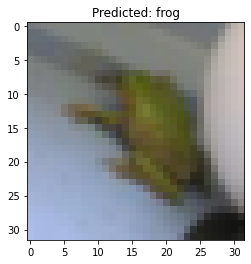

In [24]:
i = np.random.randint(low=0, high=10000)

def visualize_result(index):
    image = testloader.dataset.data[index]
    plt.imshow(image)
    
    image = transform(image)  # не забудем отмасштабировать!
    
    y_pred = net(image.view(1, 3, 32, 32))
    _, predicted = torch.max(y_pred, 1)
    
    plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')

visualize_result(i)

Даже обучив более глубокую и прокаченную (BatchNorm, Dropout) нейросеть на этих данных мы видим, что качество нас всё ещё не устраивает, в реальной жизни необходимо ошибаться не больше, чем на 5%, а часто и это уже много. Как же быть, ведь свёрточные нейросети должны хорошо классифицировать изображения?  

К сожалению, обучение нейросети с нуля на не очень большой выборке (а здесь она именно такая) часто приводит к переобучению, что плохо сказывается на тестовом качестве.  

Для того, чтобы получить более качественную модель, часто **до**обучают сильную нейросеть, обученную на ImageNet, то есть используют технику Transfer Learning. О ней речь пойдёт далее в нашем курсе.

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (официальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). Курс Стэнфорда:  http://cs231n.github.io/

3). Практически исчерпывающая информация по основам свёрточных нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/convolutional-networks/  
http://cs231n.github.io/understanding-cnn/  
http://cs231n.github.io/transfer-learning/

4). Видео о Computer Vision от Andrej Karpathy: https://www.youtube.com/watch?v=u6aEYuemt0M

---

In [27]:
def print_res(df):
    return df.sort_values(by=['avg'], ascending=False)

In [28]:
def get_f_name(f):
  arr = str(f).split(' ')
  name = arr[1]
  if name == 'method':
    name = arr[2]
  return name #  + f'<{str(f)}>'

In [82]:
import pandas as pd
global_res = pd.DataFrame(columns=['channels1', 'channels2', 'channels3', 'kernel_size1', 'kernel_size2', 'kernel_size3', 'fc1', 'fc2', 'fc3', 'is_max_pool', 'activation', 'avg', 'max', 'min', 'ch_c', 'conv_c', 'fc_c', 'num_epochs', 'lr'])

In [34]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(str(device))

cpu


In [74]:
class SimpleConvNet_my(nn.Module):
    def __init__(self, channels1, channels2, kernel_size1, kernel_size2, fc1, fc2, is_max_pool = True, activation=F.relu):
        # вызов конструктора предка
        super(SimpleConvNet_my, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.channels1 = channels1
        self.channels2 = channels2
        self.kernel_size1 = kernel_size1
        self.kernel_size2 = kernel_size2
        self.fc1_c = fc1
        self.fc2_c = fc2
        self.is_max_pool = is_max_pool
        self.activation = activation
        self.num_epochs = 0

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels1, kernel_size=kernel_size1)
        new_size = 32 - kernel_size1 + 1
        if is_max_pool:
          self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        else:
          self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        new_size = new_size // 2
        self.conv2 = nn.Conv2d(in_channels=channels1, out_channels=channels2, kernel_size=kernel_size2)
        new_size = new_size - kernel_size2 + 1
        new_size = new_size // 2

        self.fc1_size = new_size * new_size * channels2

        self.fc1 = nn.Linear(new_size * new_size * channels2, fc1)  # !!!
        self.fc2 = nn.Linear(fc1, fc2)
        self.fc3 = nn.Linear(fc2, 10)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        #print(x.shape)
        x = self.pool(self.activation(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, self.fc1_size)  # !!!
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

    def train(self, learning_rate = 1e-4, num_epochs = 3):
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        # итерируемся
        for epoch in tqdm_notebook(range(num_epochs)):
            running_loss = 0.0
            for i, batch in enumerate(tqdm_notebook(trainloader)):
                # так получаем текущий батч
                X_batch, y_batch = batch
                global device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                # обнуляем веса
                optimizer.zero_grad()

                # forward + backward + optimize
                y_pred = self(X_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward()
                optimizer.step()

                # выведем текущий loss
                running_loss += loss.item()
                # выведем качество каждые 2000 батчей
                if i % 2000 == 1999:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0
          
        print('fin')

    def validatee(self):
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                y_pred = self(images)
                _, predicted = torch.max(y_pred, 1)
                c = (predicted == labels).squeeze()
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
        res = []
        for i in range(10):
            tmp = 100 * class_correct[i] / class_total[i]
            res.append(tmp)
            print('Accuracy of %2s : %2d %%' % (
                classes[i], tmp))
          
        class_correct_t = sum(class_correct)
        class_total_t = sum(class_total)

        rrr = (100. * class_correct_t / class_total_t)
        print('\nTotal accuracy AVG:', rrr)
        print(f'max={max(res)}; min={min(res)}')  
        rezzz = [
              self.channels1,
              self.channels2,
              0, 
              self.kernel_size1,
              self.kernel_size2,
              0,
              self.fc1_c,
              self.fc2_c,
              0, 
              self.is_max_pool,
              get_f_name(self.activation),
              rrr,
              round(max(res), 2),
              round(min(res), 2),
              2,
              2,
              2,
              self.num_epochs,
              self.learning_rate
        ]    
        print(len(rezzz), rezzz)
        global_res.loc[len(global_res)] = rezzz

In [31]:
functions = [F.elu, F.softsign, torch.tanh] 
kernels = [[5, 5], [7, 3]]
fcs = [[120, 84], [200, 100]]
is_max_pools = [True]

In [39]:
for function in tqdm_notebook(functions):
    for kernel in tqdm_notebook(kernels):
        for fc in tqdm_notebook(fcs):
            for is_max_pool in tqdm_notebook(is_max_pools): 
                net = SimpleConvNet_my(6, 16, kernel[0], kernel[1], fc[0], fc[1], is_max_pool, function)
                net.to(device)
                net.train()
                net.validatee()
                print_res(global_res)

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/2248802741.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for function in tqdm_notebook(functions):


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/2248802741.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for kernel in tqdm_notebook(kernels):


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/2248802741.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fc in tqdm_notebook(fcs):


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/2248802741.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for is_max_pool in tqdm_notebook(is_max_pools):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/332785600.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/332785600.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 1.976
[1,  4000] loss: 1.733
[1,  6000] loss: 1.621
[1,  8000] loss: 1.553
[1, 10000] loss: 1.517
[1, 12000] loss: 1.490


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.456
[2,  4000] loss: 1.452
[2,  6000] loss: 1.409
[2,  8000] loss: 1.395
[2, 10000] loss: 1.394
[2, 12000] loss: 1.371


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.322
[3,  4000] loss: 1.349
[3,  6000] loss: 1.325
[3,  8000] loss: 1.325
[3, 10000] loss: 1.294
[3, 12000] loss: 1.303
fin
Accuracy of plane : 59 %
Accuracy of car : 70 %
Accuracy of bird : 34 %
Accuracy of cat : 31 %
Accuracy of deer : 39 %
Accuracy of dog : 51 %
Accuracy of frog : 64 %
Accuracy of horse : 63 %
Accuracy of ship : 65 %
Accuracy of truck : 54 %

Total accuracy AVG: 53.58
max=70.7; min=31.8


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 1.964
[1,  4000] loss: 1.723
[1,  6000] loss: 1.615
[1,  8000] loss: 1.540
[1, 10000] loss: 1.512
[1, 12000] loss: 1.473


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.422
[2,  4000] loss: 1.425
[2,  6000] loss: 1.388
[2,  8000] loss: 1.372
[2, 10000] loss: 1.350
[2, 12000] loss: 1.330


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.305
[3,  4000] loss: 1.289
[3,  6000] loss: 1.282
[3,  8000] loss: 1.263
[3, 10000] loss: 1.241
[3, 12000] loss: 1.242
fin
Accuracy of plane : 57 %
Accuracy of car : 77 %
Accuracy of bird : 28 %
Accuracy of cat : 39 %
Accuracy of deer : 63 %
Accuracy of dog : 43 %
Accuracy of frog : 66 %
Accuracy of horse : 54 %
Accuracy of ship : 67 %
Accuracy of truck : 55 %

Total accuracy AVG: 55.33
max=77.1; min=28.9


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 1.985
[1,  4000] loss: 1.797
[1,  6000] loss: 1.676
[1,  8000] loss: 1.622
[1, 10000] loss: 1.576
[1, 12000] loss: 1.550


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.500
[2,  4000] loss: 1.487
[2,  6000] loss: 1.483
[2,  8000] loss: 1.454
[2, 10000] loss: 1.443
[2, 12000] loss: 1.409


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.398
[3,  4000] loss: 1.391
[3,  6000] loss: 1.370
[3,  8000] loss: 1.355
[3, 10000] loss: 1.323
[3, 12000] loss: 1.318
fin
Accuracy of plane : 49 %
Accuracy of car : 67 %
Accuracy of bird : 31 %
Accuracy of cat : 40 %
Accuracy of deer : 39 %
Accuracy of dog : 41 %
Accuracy of frog : 61 %
Accuracy of horse : 62 %
Accuracy of ship : 67 %
Accuracy of truck : 60 %

Total accuracy AVG: 52.2
max=67.8; min=31.5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 1.933
[1,  4000] loss: 1.681
[1,  6000] loss: 1.595
[1,  8000] loss: 1.540
[1, 10000] loss: 1.517
[1, 12000] loss: 1.497


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.456
[2,  4000] loss: 1.439
[2,  6000] loss: 1.399
[2,  8000] loss: 1.374
[2, 10000] loss: 1.385
[2, 12000] loss: 1.359


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.321
[3,  4000] loss: 1.333
[3,  6000] loss: 1.313
[3,  8000] loss: 1.325
[3, 10000] loss: 1.308
[3, 12000] loss: 1.291
fin
Accuracy of plane : 55 %
Accuracy of car : 63 %
Accuracy of bird : 37 %
Accuracy of cat : 43 %
Accuracy of deer : 32 %
Accuracy of dog : 42 %
Accuracy of frog : 67 %
Accuracy of horse : 64 %
Accuracy of ship : 69 %
Accuracy of truck : 57 %

Total accuracy AVG: 53.24
max=69.2; min=32.4


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 2.020
[1,  4000] loss: 1.856
[1,  6000] loss: 1.754
[1,  8000] loss: 1.677
[1, 10000] loss: 1.617
[1, 12000] loss: 1.569


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.515
[2,  4000] loss: 1.489
[2,  6000] loss: 1.451
[2,  8000] loss: 1.459
[2, 10000] loss: 1.445
[2, 12000] loss: 1.407


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.375
[3,  4000] loss: 1.380
[3,  6000] loss: 1.373
[3,  8000] loss: 1.353
[3, 10000] loss: 1.318
[3, 12000] loss: 1.333
fin
Accuracy of plane : 53 %
Accuracy of car : 67 %
Accuracy of bird : 39 %
Accuracy of cat : 34 %
Accuracy of deer : 31 %
Accuracy of dog : 49 %
Accuracy of frog : 63 %
Accuracy of horse : 61 %
Accuracy of ship : 62 %
Accuracy of truck : 55 %

Total accuracy AVG: 51.88
max=67.0; min=31.1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 2.041
[1,  4000] loss: 1.858
[1,  6000] loss: 1.742
[1,  8000] loss: 1.653
[1, 10000] loss: 1.606
[1, 12000] loss: 1.569


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.513
[2,  4000] loss: 1.507
[2,  6000] loss: 1.454
[2,  8000] loss: 1.447
[2, 10000] loss: 1.428
[2, 12000] loss: 1.416


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.364
[3,  4000] loss: 1.367
[3,  6000] loss: 1.347
[3,  8000] loss: 1.353
[3, 10000] loss: 1.331
[3, 12000] loss: 1.324
fin
Accuracy of plane : 54 %
Accuracy of car : 55 %
Accuracy of bird : 41 %
Accuracy of cat : 30 %
Accuracy of deer : 38 %
Accuracy of dog : 51 %
Accuracy of frog : 64 %
Accuracy of horse : 65 %
Accuracy of ship : 68 %
Accuracy of truck : 61 %

Total accuracy AVG: 53.17
max=68.6; min=30.7


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 2.051
[1,  4000] loss: 1.891
[1,  6000] loss: 1.756
[1,  8000] loss: 1.680
[1, 10000] loss: 1.640
[1, 12000] loss: 1.600


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.570
[2,  4000] loss: 1.558
[2,  6000] loss: 1.509
[2,  8000] loss: 1.501
[2, 10000] loss: 1.489
[2, 12000] loss: 1.488


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.448
[3,  4000] loss: 1.440
[3,  6000] loss: 1.438
[3,  8000] loss: 1.413
[3, 10000] loss: 1.408
[3, 12000] loss: 1.402
fin
Accuracy of plane : 53 %
Accuracy of car : 57 %
Accuracy of bird : 41 %
Accuracy of cat : 26 %
Accuracy of deer : 32 %
Accuracy of dog : 49 %
Accuracy of frog : 56 %
Accuracy of horse : 59 %
Accuracy of ship : 68 %
Accuracy of truck : 51 %

Total accuracy AVG: 49.7
max=68.1; min=26.9


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 2.028
[1,  4000] loss: 1.840
[1,  6000] loss: 1.722
[1,  8000] loss: 1.654
[1, 10000] loss: 1.603
[1, 12000] loss: 1.598


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.566
[2,  4000] loss: 1.535
[2,  6000] loss: 1.506
[2,  8000] loss: 1.469
[2, 10000] loss: 1.465
[2, 12000] loss: 1.457


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.432
[3,  4000] loss: 1.397
[3,  6000] loss: 1.395
[3,  8000] loss: 1.398
[3, 10000] loss: 1.409
[3, 12000] loss: 1.368
fin
Accuracy of plane : 48 %
Accuracy of car : 60 %
Accuracy of bird : 29 %
Accuracy of cat : 32 %
Accuracy of deer : 41 %
Accuracy of dog : 49 %
Accuracy of frog : 66 %
Accuracy of horse : 59 %
Accuracy of ship : 63 %
Accuracy of truck : 52 %

Total accuracy AVG: 50.12
max=66.1; min=29.3


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 2.007
[1,  4000] loss: 1.830
[1,  6000] loss: 1.668
[1,  8000] loss: 1.590
[1, 10000] loss: 1.579
[1, 12000] loss: 1.529


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.490
[2,  4000] loss: 1.450
[2,  6000] loss: 1.447
[2,  8000] loss: 1.429
[2, 10000] loss: 1.418
[2, 12000] loss: 1.381


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.371
[3,  4000] loss: 1.357
[3,  6000] loss: 1.336
[3,  8000] loss: 1.347
[3, 10000] loss: 1.321
[3, 12000] loss: 1.315
fin
Accuracy of plane : 52 %
Accuracy of car : 65 %
Accuracy of bird : 30 %
Accuracy of cat : 30 %
Accuracy of deer : 48 %
Accuracy of dog : 50 %
Accuracy of frog : 60 %
Accuracy of horse : 64 %
Accuracy of ship : 65 %
Accuracy of truck : 61 %

Total accuracy AVG: 52.98
max=65.3; min=30.8


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 1.973
[1,  4000] loss: 1.761
[1,  6000] loss: 1.642
[1,  8000] loss: 1.565
[1, 10000] loss: 1.515
[1, 12000] loss: 1.492


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.459
[2,  4000] loss: 1.416
[2,  6000] loss: 1.415
[2,  8000] loss: 1.391
[2, 10000] loss: 1.390
[2, 12000] loss: 1.369


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.345
[3,  4000] loss: 1.338
[3,  6000] loss: 1.307
[3,  8000] loss: 1.310
[3, 10000] loss: 1.288
[3, 12000] loss: 1.302
fin
Accuracy of plane : 62 %
Accuracy of car : 69 %
Accuracy of bird : 42 %
Accuracy of cat : 39 %
Accuracy of deer : 28 %
Accuracy of dog : 43 %
Accuracy of frog : 75 %
Accuracy of horse : 62 %
Accuracy of ship : 62 %
Accuracy of truck : 53 %

Total accuracy AVG: 54.04
max=75.9; min=28.4


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 2.006
[1,  4000] loss: 1.840
[1,  6000] loss: 1.752
[1,  8000] loss: 1.654
[1, 10000] loss: 1.579
[1, 12000] loss: 1.545


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.504
[2,  4000] loss: 1.478
[2,  6000] loss: 1.437
[2,  8000] loss: 1.453
[2, 10000] loss: 1.427
[2, 12000] loss: 1.397


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.366
[3,  4000] loss: 1.374
[3,  6000] loss: 1.375
[3,  8000] loss: 1.352
[3, 10000] loss: 1.345
[3, 12000] loss: 1.351
fin
Accuracy of plane : 51 %
Accuracy of car : 70 %
Accuracy of bird : 33 %
Accuracy of cat : 29 %
Accuracy of deer : 40 %
Accuracy of dog : 45 %
Accuracy of frog : 65 %
Accuracy of horse : 62 %
Accuracy of ship : 67 %
Accuracy of truck : 50 %

Total accuracy AVG: 51.67
max=70.8; min=29.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 1.944
[1,  4000] loss: 1.727
[1,  6000] loss: 1.685
[1,  8000] loss: 1.609
[1, 10000] loss: 1.573
[1, 12000] loss: 1.558


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.526
[2,  4000] loss: 1.484
[2,  6000] loss: 1.467
[2,  8000] loss: 1.462
[2, 10000] loss: 1.460
[2, 12000] loss: 1.432


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.397
[3,  4000] loss: 1.392
[3,  6000] loss: 1.389
[3,  8000] loss: 1.356
[3, 10000] loss: 1.370
[3, 12000] loss: 1.368
fin
Accuracy of plane : 55 %
Accuracy of car : 59 %
Accuracy of bird : 28 %
Accuracy of cat : 29 %
Accuracy of deer : 42 %
Accuracy of dog : 44 %
Accuracy of frog : 65 %
Accuracy of horse : 66 %
Accuracy of ship : 66 %
Accuracy of truck : 63 %

Total accuracy AVG: 52.05
max=66.9; min=28.2


In [68]:
print_res(global_res)

,channels1,channels2,channels3,kernel_size1,kernel_size2,kernel_size3,fc1,fc2,fc3,is_max_pool,activation,avg,max,min,ch_c,conv_c,fc_c,num_epochs,lr
14,6,16,0,5,5,0,200,100,0,True,elu,64.77,77.9,43.8,2,2,2,13,0.0001
13,6,16,0,5,5,0,200,100,0,True,elu,61.26,78.5,37.7,2,2,2,7,0.0001
1,6,16,0,5,5,0,200,100,0,True,elu,55.33,77.1,28.9,2,2,2,3,0.0001
12,6,16,0,5,5,0,200,100,0,True,elu,54.68,70.1,32.2,2,2,2,3,0.0001
9,6,16,0,5,5,0,200,100,0,True,tanh,54.04,75.9,28.4,2,2,2,3,0.0001
0,6,16,0,5,5,0,120,84,0,True,elu,53.58,70.7,31.8,2,2,2,3,0.0001
3,6,16,0,7,3,0,200,100,0,True,elu,53.24,69.2,32.4,2,2,2,3,0.0001
5,6,16,0,5,5,0,200,100,0,True,softsign,53.17,68.6,30.7,2,2,2,3,0.0001
8,6,16,0,5,5,0,120,84,0,True,tanh,52.98,65.3,30.8,2,2,2,3,0.0001
2,6,16,0,7,3,0,120,84,0,True,elu,52.20,67.8,31.5,2,2,2,3,0.0001


In [62]:
# global_res.to_csv('2-2-2--13-epoch--cifar10.csv', sep='\t', encoding='utf-8')

In [67]:
# global_res['num_epochs'] = 3
# global_res['lr'] = 1e-4


In [59]:
# global_res.loc[13,'num_epochs'] = 7

Лучашя сеть из прошлой лабы показала удручающий результат 55%. Пробую увеличить кол-во эпох и изменить learning_rates

In [83]:
# functions = [F.elu, F.leaky_relu] 
functions = [F.elu] 
num_epochssss = [3, 7, 13]
learning_rates = [5e-3, 5e-4, 5e-5]

In [84]:
for function in tqdm_notebook(functions):
    for num_epochs in tqdm_notebook(num_epochssss):
        for learning_rate in tqdm_notebook(learning_rates):
            net = SimpleConvNet_my(6, 16, 5, 5, 200, 100, True, function)
            net.to(device)
            net.train(num_epochs=num_epochs, learning_rate=learning_rate)
            net.validatee()
            # print_res(global_res)

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/2095501102.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for function in tqdm_notebook(functions):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/2095501102.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epochs in tqdm_notebook(num_epochssss):


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/2095501102.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for learning_rate in tqdm_notebook(learning_rates):


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/2477625818.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/2477625818.py:54: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 2.432
[1,  4000] loss: 2.486
[1,  6000] loss: 2.487
[1,  8000] loss: 2.483
[1, 10000] loss: 2.486
[1, 12000] loss: 2.493


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 2.491
[2,  4000] loss: 2.479
[2,  6000] loss: 2.485
[2,  8000] loss: 2.483
[2, 10000] loss: 2.487
[2, 12000] loss: 2.487


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 2.485
[3,  4000] loss: 2.481
[3,  6000] loss: 2.480
[3,  8000] loss: 2.498
[3, 10000] loss: 2.489
[3, 12000] loss: 2.477
fin
Accuracy of plane :  0 %
Accuracy of car :  0 %
Accuracy of bird :  0 %
Accuracy of cat :  0 %
Accuracy of deer : 100 %
Accuracy of dog :  0 %
Accuracy of frog :  0 %
Accuracy of horse :  0 %
Accuracy of ship :  0 %
Accuracy of truck :  0 %

Total accuracy AVG: 10.0
max=100.0; min=0.0
19 [6, 16, 0, 5, 5, 0, 200, 100, 0, True, 'elu', 10.0, 100.0, 0.0, 2, 2, 2, 3, 0.005]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 1.784
[1,  4000] loss: 1.575
[1,  6000] loss: 1.473
[1,  8000] loss: 1.413
[1, 10000] loss: 1.368
[1, 12000] loss: 1.311


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.226
[2,  4000] loss: 1.218
[2,  6000] loss: 1.208
[2,  8000] loss: 1.202
[2, 10000] loss: 1.159
[2, 12000] loss: 1.148


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.058
[3,  4000] loss: 1.052
[3,  6000] loss: 1.033
[3,  8000] loss: 1.044
[3, 10000] loss: 1.045
[3, 12000] loss: 1.011
fin
Accuracy of plane : 54 %
Accuracy of car : 69 %
Accuracy of bird : 48 %
Accuracy of cat : 53 %
Accuracy of deer : 55 %
Accuracy of dog : 46 %
Accuracy of frog : 65 %
Accuracy of horse : 68 %
Accuracy of ship : 83 %
Accuracy of truck : 69 %

Total accuracy AVG: 61.42
max=83.0; min=46.9
19 [6, 16, 0, 5, 5, 0, 200, 100, 0, True, 'elu', 61.42, 83.0, 46.9, 2, 2, 2, 3, 0.0005]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 2.049
[1,  4000] loss: 1.880
[1,  6000] loss: 1.777
[1,  8000] loss: 1.695
[1, 10000] loss: 1.647
[1, 12000] loss: 1.609


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.559
[2,  4000] loss: 1.547
[2,  6000] loss: 1.494
[2,  8000] loss: 1.489
[2, 10000] loss: 1.475
[2, 12000] loss: 1.455


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.435
[3,  4000] loss: 1.421
[3,  6000] loss: 1.399
[3,  8000] loss: 1.387
[3, 10000] loss: 1.381
[3, 12000] loss: 1.378
fin
Accuracy of plane : 55 %
Accuracy of car : 62 %
Accuracy of bird : 37 %
Accuracy of cat : 30 %
Accuracy of deer : 36 %
Accuracy of dog : 36 %
Accuracy of frog : 71 %
Accuracy of horse : 60 %
Accuracy of ship : 59 %
Accuracy of truck : 57 %

Total accuracy AVG: 50.85
max=71.6; min=30.3
19 [6, 16, 0, 5, 5, 0, 200, 100, 0, True, 'elu', 50.85, 71.6, 30.3, 2, 2, 2, 3, 5e-05]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 2.303
[1,  4000] loss: 2.461
[1,  6000] loss: 2.488
[1,  8000] loss: 2.485
[1, 10000] loss: 2.486
[1, 12000] loss: 2.486


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 2.483
[2,  4000] loss: 2.481
[2,  6000] loss: 2.475
[2,  8000] loss: 2.494
[2, 10000] loss: 2.493
[2, 12000] loss: 2.489


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 2.488
[3,  4000] loss: 2.478
[3,  6000] loss: 2.487
[3,  8000] loss: 2.480
[3, 10000] loss: 2.480
[3, 12000] loss: 2.504


  0%|          | 0/12500 [00:00<?, ?it/s]

[4,  2000] loss: 2.488
[4,  4000] loss: 2.494
[4,  6000] loss: 2.495
[4,  8000] loss: 2.486
[4, 10000] loss: 2.493
[4, 12000] loss: 2.480


  0%|          | 0/12500 [00:00<?, ?it/s]

[5,  2000] loss: 2.488
[5,  4000] loss: 2.474
[5,  6000] loss: 2.498
[5,  8000] loss: 2.484
[5, 10000] loss: 2.485
[5, 12000] loss: 2.484


  0%|          | 0/12500 [00:00<?, ?it/s]

[6,  2000] loss: 2.496
[6,  4000] loss: 2.478
[6,  6000] loss: 2.496
[6,  8000] loss: 2.476
[6, 10000] loss: 2.484
[6, 12000] loss: 2.482


  0%|          | 0/12500 [00:00<?, ?it/s]

[7,  2000] loss: 2.478
[7,  4000] loss: 2.484
[7,  6000] loss: 2.496
[7,  8000] loss: 2.490
[7, 10000] loss: 2.482
[7, 12000] loss: 2.486
fin
Accuracy of plane :  0 %
Accuracy of car : 100 %
Accuracy of bird :  0 %
Accuracy of cat :  0 %
Accuracy of deer :  0 %
Accuracy of dog :  0 %
Accuracy of frog :  0 %
Accuracy of horse :  0 %
Accuracy of ship :  0 %
Accuracy of truck :  0 %

Total accuracy AVG: 10.0
max=100.0; min=0.0
19 [6, 16, 0, 5, 5, 0, 200, 100, 0, True, 'elu', 10.0, 100.0, 0.0, 2, 2, 2, 7, 0.005]


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 1.779
[1,  4000] loss: 1.556
[1,  6000] loss: 1.455
[1,  8000] loss: 1.390
[1, 10000] loss: 1.310
[1, 12000] loss: 1.279


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.212
[2,  4000] loss: 1.175
[2,  6000] loss: 1.159
[2,  8000] loss: 1.142
[2, 10000] loss: 1.130
[2, 12000] loss: 1.086


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.027
[3,  4000] loss: 1.011
[3,  6000] loss: 1.001
[3,  8000] loss: 0.994
[3, 10000] loss: 0.996
[3, 12000] loss: 0.982


  0%|          | 0/12500 [00:00<?, ?it/s]

[4,  2000] loss: 0.872
[4,  4000] loss: 0.887
[4,  6000] loss: 0.896
[4,  8000] loss: 0.892
[4, 10000] loss: 0.899
[4, 12000] loss: 0.898


  0%|          | 0/12500 [00:00<?, ?it/s]

[5,  2000] loss: 0.772
[5,  4000] loss: 0.800
[5,  6000] loss: 0.808
[5,  8000] loss: 0.814
[5, 10000] loss: 0.813
[5, 12000] loss: 0.821


  0%|          | 0/12500 [00:00<?, ?it/s]

[6,  2000] loss: 0.692
[6,  4000] loss: 0.695
[6,  6000] loss: 0.740
[6,  8000] loss: 0.744
[6, 10000] loss: 0.747
[6, 12000] loss: 0.738


  0%|          | 0/12500 [00:00<?, ?it/s]

[7,  2000] loss: 0.609
[7,  4000] loss: 0.642
[7,  6000] loss: 0.644
[7,  8000] loss: 0.686
[7, 10000] loss: 0.687
[7, 12000] loss: 0.673
fin
Accuracy of plane : 73 %
Accuracy of car : 78 %
Accuracy of bird : 58 %
Accuracy of cat : 46 %
Accuracy of deer : 65 %
Accuracy of dog : 59 %
Accuracy of frog : 66 %
Accuracy of horse : 65 %
Accuracy of ship : 77 %
Accuracy of truck : 73 %

Total accuracy AVG: 66.46
max=78.1; min=46.7
19 [6, 16, 0, 5, 5, 0, 200, 100, 0, True, 'elu', 66.46, 78.1, 46.7, 2, 2, 2, 7, 0.0005]


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 2.018
[1,  4000] loss: 1.791
[1,  6000] loss: 1.678
[1,  8000] loss: 1.660
[1, 10000] loss: 1.591
[1, 12000] loss: 1.581


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.528
[2,  4000] loss: 1.514
[2,  6000] loss: 1.454
[2,  8000] loss: 1.481
[2, 10000] loss: 1.469
[2, 12000] loss: 1.443


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.409
[3,  4000] loss: 1.409
[3,  6000] loss: 1.401
[3,  8000] loss: 1.376
[3, 10000] loss: 1.363
[3, 12000] loss: 1.386


  0%|          | 0/12500 [00:00<?, ?it/s]

[4,  2000] loss: 1.330
[4,  4000] loss: 1.334
[4,  6000] loss: 1.325
[4,  8000] loss: 1.333
[4, 10000] loss: 1.314
[4, 12000] loss: 1.309


  0%|          | 0/12500 [00:00<?, ?it/s]

[5,  2000] loss: 1.264
[5,  4000] loss: 1.282
[5,  6000] loss: 1.279
[5,  8000] loss: 1.279
[5, 10000] loss: 1.257
[5, 12000] loss: 1.264


  0%|          | 0/12500 [00:00<?, ?it/s]

[6,  2000] loss: 1.216
[6,  4000] loss: 1.235
[6,  6000] loss: 1.239
[6,  8000] loss: 1.229
[6, 10000] loss: 1.233
[6, 12000] loss: 1.209


  0%|          | 0/12500 [00:00<?, ?it/s]

[7,  2000] loss: 1.210
[7,  4000] loss: 1.199
[7,  6000] loss: 1.182
[7,  8000] loss: 1.175
[7, 10000] loss: 1.182
[7, 12000] loss: 1.178
fin
Accuracy of plane : 61 %
Accuracy of car : 73 %
Accuracy of bird : 32 %
Accuracy of cat : 36 %
Accuracy of deer : 33 %
Accuracy of dog : 50 %
Accuracy of frog : 80 %
Accuracy of horse : 66 %
Accuracy of ship : 69 %
Accuracy of truck : 60 %

Total accuracy AVG: 56.36
max=80.4; min=32.2
19 [6, 16, 0, 5, 5, 0, 200, 100, 0, True, 'elu', 56.36, 80.4, 32.2, 2, 2, 2, 7, 5e-05]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 2.439
[1,  4000] loss: 2.479
[1,  6000] loss: 2.493
[1,  8000] loss: 2.485
[1, 10000] loss: 2.488
[1, 12000] loss: 2.490


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 2.497
[2,  4000] loss: 2.483
[2,  6000] loss: 2.485
[2,  8000] loss: 2.499
[2, 10000] loss: 2.480
[2, 12000] loss: 2.527


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 2.487
[3,  4000] loss: 2.488
[3,  6000] loss: 2.479
[3,  8000] loss: 2.473
[3, 10000] loss: 2.486
[3, 12000] loss: 2.490


  0%|          | 0/12500 [00:00<?, ?it/s]

[4,  2000] loss: 2.489
[4,  4000] loss: 2.480
[4,  6000] loss: 2.498
[4,  8000] loss: 2.481
[4, 10000] loss: 2.491
[4, 12000] loss: 2.489


  0%|          | 0/12500 [00:00<?, ?it/s]

[5,  2000] loss: 2.487
[5,  4000] loss: 2.490
[5,  6000] loss: 2.492
[5,  8000] loss: 2.490
[5, 10000] loss: 2.487
[5, 12000] loss: 2.495


  0%|          | 0/12500 [00:00<?, ?it/s]

[6,  2000] loss: 2.483
[6,  4000] loss: 2.483
[6,  6000] loss: 2.494
[6,  8000] loss: 2.491
[6, 10000] loss: 2.487
[6, 12000] loss: 2.496


  0%|          | 0/12500 [00:00<?, ?it/s]

[7,  2000] loss: 2.492
[7,  4000] loss: 2.503
[7,  6000] loss: 2.481
[7,  8000] loss: 2.483
[7, 10000] loss: 2.495
[7, 12000] loss: 2.487


  0%|          | 0/12500 [00:00<?, ?it/s]

[8,  2000] loss: 2.487
[8,  4000] loss: 2.490
[8,  6000] loss: 2.491
[8,  8000] loss: 2.484
[8, 10000] loss: 2.485
[8, 12000] loss: 2.478


  0%|          | 0/12500 [00:00<?, ?it/s]

[9,  2000] loss: 2.482
[9,  4000] loss: 2.477
[9,  6000] loss: 2.480
[9,  8000] loss: 2.499
[9, 10000] loss: 2.485
[9, 12000] loss: 2.484


  0%|          | 0/12500 [00:00<?, ?it/s]

[10,  2000] loss: 2.492
[10,  4000] loss: 2.493
[10,  6000] loss: 2.492
[10,  8000] loss: 2.490
[10, 10000] loss: 2.481
[10, 12000] loss: 2.494


  0%|          | 0/12500 [00:00<?, ?it/s]

[11,  2000] loss: 2.493
[11,  4000] loss: 2.484
[11,  6000] loss: 2.488
[11,  8000] loss: 2.482
[11, 10000] loss: 2.487
[11, 12000] loss: 2.478


  0%|          | 0/12500 [00:00<?, ?it/s]

[12,  2000] loss: 2.492
[12,  4000] loss: 2.498
[12,  6000] loss: 2.500
[12,  8000] loss: 2.487
[12, 10000] loss: 2.486
[12, 12000] loss: 2.490


  0%|          | 0/12500 [00:00<?, ?it/s]

[13,  2000] loss: 2.489
[13,  4000] loss: 2.480
[13,  6000] loss: 2.477
[13,  8000] loss: 2.491
[13, 10000] loss: 2.484
[13, 12000] loss: 2.497
fin
Accuracy of plane :  0 %
Accuracy of car :  0 %
Accuracy of bird : 100 %
Accuracy of cat :  0 %
Accuracy of deer :  0 %
Accuracy of dog :  0 %
Accuracy of frog :  0 %
Accuracy of horse :  0 %
Accuracy of ship :  0 %
Accuracy of truck :  0 %

Total accuracy AVG: 10.0
max=100.0; min=0.0
19 [6, 16, 0, 5, 5, 0, 200, 100, 0, True, 'elu', 10.0, 100.0, 0.0, 2, 2, 2, 13, 0.005]


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 1.765
[1,  4000] loss: 1.516
[1,  6000] loss: 1.425
[1,  8000] loss: 1.346
[1, 10000] loss: 1.325
[1, 12000] loss: 1.269


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.195
[2,  4000] loss: 1.165
[2,  6000] loss: 1.176
[2,  8000] loss: 1.133
[2, 10000] loss: 1.131
[2, 12000] loss: 1.130


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.026
[3,  4000] loss: 1.020
[3,  6000] loss: 1.015
[3,  8000] loss: 1.029
[3, 10000] loss: 1.025
[3, 12000] loss: 1.014


  0%|          | 0/12500 [00:00<?, ?it/s]

[4,  2000] loss: 0.911
[4,  4000] loss: 0.909
[4,  6000] loss: 0.906
[4,  8000] loss: 0.924
[4, 10000] loss: 0.924
[4, 12000] loss: 0.923


  0%|          | 0/12500 [00:00<?, ?it/s]

[5,  2000] loss: 0.799
[5,  4000] loss: 0.812
[5,  6000] loss: 0.832
[5,  8000] loss: 0.852
[5, 10000] loss: 0.823
[5, 12000] loss: 0.836


  0%|          | 0/12500 [00:00<?, ?it/s]

[6,  2000] loss: 0.726
[6,  4000] loss: 0.720
[6,  6000] loss: 0.752
[6,  8000] loss: 0.752
[6, 10000] loss: 0.761
[6, 12000] loss: 0.767


  0%|          | 0/12500 [00:00<?, ?it/s]

[7,  2000] loss: 0.622
[7,  4000] loss: 0.647
[7,  6000] loss: 0.668
[7,  8000] loss: 0.692
[7, 10000] loss: 0.721
[7, 12000] loss: 0.695


  0%|          | 0/12500 [00:00<?, ?it/s]

[8,  2000] loss: 0.553
[8,  4000] loss: 0.591
[8,  6000] loss: 0.599
[8,  8000] loss: 0.619
[8, 10000] loss: 0.637
[8, 12000] loss: 0.643


  0%|          | 0/12500 [00:00<?, ?it/s]

[9,  2000] loss: 0.479
[9,  4000] loss: 0.539
[9,  6000] loss: 0.551
[9,  8000] loss: 0.588
[9, 10000] loss: 0.572
[9, 12000] loss: 0.587


  0%|          | 0/12500 [00:00<?, ?it/s]

[10,  2000] loss: 0.444
[10,  4000] loss: 0.464
[10,  6000] loss: 0.500
[10,  8000] loss: 0.524
[10, 10000] loss: 0.541
[10, 12000] loss: 0.535


  0%|          | 0/12500 [00:00<?, ?it/s]

[11,  2000] loss: 0.397
[11,  4000] loss: 0.440
[11,  6000] loss: 0.459
[11,  8000] loss: 0.483
[11, 10000] loss: 0.479
[11, 12000] loss: 0.482


  0%|          | 0/12500 [00:00<?, ?it/s]

[12,  2000] loss: 0.364
[12,  4000] loss: 0.389
[12,  6000] loss: 0.416
[12,  8000] loss: 0.435
[12, 10000] loss: 0.433
[12, 12000] loss: 0.455


  0%|          | 0/12500 [00:00<?, ?it/s]

[13,  2000] loss: 0.306
[13,  4000] loss: 0.355
[13,  6000] loss: 0.380
[13,  8000] loss: 0.396
[13, 10000] loss: 0.417
[13, 12000] loss: 0.449
fin
Accuracy of plane : 71 %
Accuracy of car : 76 %
Accuracy of bird : 53 %
Accuracy of cat : 43 %
Accuracy of deer : 54 %
Accuracy of dog : 54 %
Accuracy of frog : 78 %
Accuracy of horse : 74 %
Accuracy of ship : 77 %
Accuracy of truck : 71 %

Total accuracy AVG: 65.48
max=78.9; min=43.2
19 [6, 16, 0, 5, 5, 0, 200, 100, 0, True, 'elu', 65.48, 78.9, 43.2, 2, 2, 2, 13, 0.0005]


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 2.026
[1,  4000] loss: 1.857
[1,  6000] loss: 1.735
[1,  8000] loss: 1.655
[1, 10000] loss: 1.626
[1, 12000] loss: 1.536


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.505
[2,  4000] loss: 1.514
[2,  6000] loss: 1.494
[2,  8000] loss: 1.455
[2, 10000] loss: 1.446
[2, 12000] loss: 1.452


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.426
[3,  4000] loss: 1.410
[3,  6000] loss: 1.404
[3,  8000] loss: 1.397
[3, 10000] loss: 1.388
[3, 12000] loss: 1.363


  0%|          | 0/12500 [00:00<?, ?it/s]

[4,  2000] loss: 1.356
[4,  4000] loss: 1.354
[4,  6000] loss: 1.328
[4,  8000] loss: 1.331
[4, 10000] loss: 1.332
[4, 12000] loss: 1.301


  0%|          | 0/12500 [00:00<?, ?it/s]

[5,  2000] loss: 1.299
[5,  4000] loss: 1.289
[5,  6000] loss: 1.283
[5,  8000] loss: 1.289
[5, 10000] loss: 1.260
[5, 12000] loss: 1.260


  0%|          | 0/12500 [00:00<?, ?it/s]

[6,  2000] loss: 1.253
[6,  4000] loss: 1.245
[6,  6000] loss: 1.235
[6,  8000] loss: 1.242
[6, 10000] loss: 1.212
[6, 12000] loss: 1.226


  0%|          | 0/12500 [00:00<?, ?it/s]

[7,  2000] loss: 1.200
[7,  4000] loss: 1.192
[7,  6000] loss: 1.194
[7,  8000] loss: 1.196
[7, 10000] loss: 1.177
[7, 12000] loss: 1.224


  0%|          | 0/12500 [00:00<?, ?it/s]

[8,  2000] loss: 1.171
[8,  4000] loss: 1.171
[8,  6000] loss: 1.161
[8,  8000] loss: 1.169
[8, 10000] loss: 1.150
[8, 12000] loss: 1.155


  0%|          | 0/12500 [00:00<?, ?it/s]

[9,  2000] loss: 1.151
[9,  4000] loss: 1.132
[9,  6000] loss: 1.124
[9,  8000] loss: 1.139
[9, 10000] loss: 1.118
[9, 12000] loss: 1.126


  0%|          | 0/12500 [00:00<?, ?it/s]

[10,  2000] loss: 1.114
[10,  4000] loss: 1.083
[10,  6000] loss: 1.107
[10,  8000] loss: 1.121
[10, 10000] loss: 1.089
[10, 12000] loss: 1.102


  0%|          | 0/12500 [00:00<?, ?it/s]

[11,  2000] loss: 1.063
[11,  4000] loss: 1.072
[11,  6000] loss: 1.070
[11,  8000] loss: 1.078
[11, 10000] loss: 1.086
[11, 12000] loss: 1.081


  0%|          | 0/12500 [00:00<?, ?it/s]

[12,  2000] loss: 1.062
[12,  4000] loss: 1.060
[12,  6000] loss: 1.051
[12,  8000] loss: 1.056
[12, 10000] loss: 1.038
[12, 12000] loss: 1.054


  0%|          | 0/12500 [00:00<?, ?it/s]

[13,  2000] loss: 1.001
[13,  4000] loss: 1.025
[13,  6000] loss: 1.050
[13,  8000] loss: 1.016
[13, 10000] loss: 1.041
[13, 12000] loss: 1.034
fin
Accuracy of plane : 63 %
Accuracy of car : 75 %
Accuracy of bird : 42 %
Accuracy of cat : 30 %
Accuracy of deer : 55 %
Accuracy of dog : 48 %
Accuracy of frog : 73 %
Accuracy of horse : 70 %
Accuracy of ship : 77 %
Accuracy of truck : 64 %

Total accuracy AVG: 60.17
max=77.4; min=30.7
19 [6, 16, 0, 5, 5, 0, 200, 100, 0, True, 'elu', 60.17, 77.4, 30.7, 2, 2, 2, 13, 5e-05]


In [79]:
# net = SimpleConvNet_my(6, 16, 5, 5, 200, 100, True, F.elu)
# net.to(device)
# net.train(num_epochs=13)
# net.validatee()
# print_res(global_res)

In [89]:
# global_res.to_csv('elu-ne-3-7-13--lr-3-4-5.csv', sep='\t', encoding='utf-8')

Увеличение кол-ва эпох с 3 до 13 увеличело предсказание на 10% (Лучшее 64%)
Пробую уменьшить learning_rate

In [80]:
# net = SimpleConvNet_my(6, 16, 5, 5, 200, 100, True, F.leaky_relu)
# net.to(device)
# net.train(num_epochs=2) #, learning_rate=5e-5)
# net.validatee()
# print_res(global_res)

In [85]:
print_res(global_res)

,channels1,channels2,channels3,kernel_size1,kernel_size2,kernel_size3,fc1,fc2,fc3,is_max_pool,activation,avg,max,min,ch_c,conv_c,fc_c,num_epochs,lr
4,6,16,0,5,5,0,200,100,0,True,elu,66.46,78.1,46.7,2,2,2,7,0.00050
7,6,16,0,5,5,0,200,100,0,True,elu,65.48,78.9,43.2,2,2,2,13,0.00050
1,6,16,0,5,5,0,200,100,0,True,elu,61.42,83.0,46.9,2,2,2,3,0.00050
8,6,16,0,5,5,0,200,100,0,True,elu,60.17,77.4,30.7,2,2,2,13,0.00005
5,6,16,0,5,5,0,200,100,0,True,elu,56.36,80.4,32.2,2,2,2,7,0.00005
2,6,16,0,5,5,0,200,100,0,True,elu,50.85,71.6,30.3,2,2,2,3,0.00005
0,6,16,0,5,5,0,200,100,0,True,elu,10.00,100.0,0.0,2,2,2,3,0.00500
3,6,16,0,5,5,0,200,100,0,True,elu,10.00,100.0,0.0,2,2,2,7,0.00500
6,6,16,0,5,5,0,200,100,0,True,elu,10.00,100.0,0.0,2,2,2,13,0.00500


In [ ]:
лучший результат с 2 conv и 2 fc получился 66.46%

Пробую другую архитектуру с дропаутом, 3 FC и 4 conv

In [129]:
from torch.nn import Dropout
class SimpleConvNet_my2(nn.Module):
    def __init__(self, channels1, channels2, channels3, channels4, kernel_size1, kernel_size2, kernel_size3, kernel_size4, fc1, fc2, dropout, is_max_pool = True, activation=F.relu):
        # вызов конструктора предка
        super(SimpleConvNet_my2, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.channels1 = channels1
        self.channels2 = channels2
        self.kernel_size1 = kernel_size1
        self.kernel_size2 = kernel_size2
        self.fc1_c = fc1
        self.fc2_c = fc2
        self.is_max_pool = is_max_pool
        self.activation = activation
        self.num_epochs = 0

        if is_max_pool:
          self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        else:
          self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels1, kernel_size=kernel_size1)
        new_size = 32 - kernel_size1 + 1
        #new_size = new_size // 2

        self.conv2 = nn.Conv2d(in_channels=channels1, out_channels=channels2, kernel_size=kernel_size2)
        new_size = new_size - kernel_size2 + 1
        new_size = new_size // 2 #тут нет пулинга

        self.conv3 = nn.Conv2d(in_channels=channels2, out_channels=channels3, kernel_size=kernel_size3)
        new_size = new_size - kernel_size3 + 1
        #new_size = new_size // 2

        self.conv4 = nn.Conv2d(in_channels=channels3, out_channels=channels4, kernel_size=kernel_size4)
        new_size = new_size - kernel_size4 + 1
        new_size = new_size // 2

        #print(new_size)

        self.fc1_size = new_size * new_size * channels4
        
        self.fc1 = nn.Linear(self.fc1_size, fc1)  # !!!
        self.fc2 = nn.Linear(fc1, fc2)
        self.fc3 = nn.Linear(fc2, 10)
        
        # self.fc1 = nn.Linear(self.fc1_size, fc1)
        # self.fc3 = nn.Linear(fc1, 10)

        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)


    def forward(self, x):
        x = self.pool(self.activation(self.conv2(self.activation(self.conv1(x)))))
        x = self.pool(self.conv4(self.activation(self.conv3(x))))
        x = x.view(-1, self.fc1_size)
        x = self.dropout1(self.activation(self.fc1(x)))
        x = self.dropout2(self.activation(self.fc2(x)))
        x = self.fc3(x)

        return x

    def train(self, learning_rate = 1e-4, num_epochs = 3):
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        # итерируемся
        for epoch in tqdm_notebook(range(num_epochs)):
            running_loss = 0.0
            for i, batch in enumerate(tqdm_notebook(trainloader)):
                # так получаем текущий батч
                X_batch, y_batch = batch
                global device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                # обнуляем веса
                optimizer.zero_grad()

                # forward + backward + optimize
                y_pred = self(X_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward()
                optimizer.step()

                # выведем текущий loss
                running_loss += loss.item()
                # выведем качество каждые 2000 батчей
                if i % 2000 == 1999:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0
          
        print('fin')

    def validatee(self):
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                global device
                images, labels = images.to(device), labels.to(device)
                y_pred = self(images)
                _, predicted = torch.max(y_pred, 1)
                c = (predicted == labels).squeeze()
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
        res = []
        for i in range(10):
            tmp = 100 * class_correct[i] / class_total[i]
            res.append(tmp)
            print('Accuracy of %2s : %2d %%' % (
                classes[i], tmp))
          
        class_correct_t = sum(class_correct)
        class_total_t = sum(class_total)

        rrr = (100. * class_correct_t / class_total_t)
        print('\nTotal accuracy AVG:', rrr)
        print(f'max={max(res)}; min={min(res)}')  
        rezzz = [
              self.channels1,
              self.channels2,
              0, 
              self.kernel_size1,
              self.kernel_size2,
              0,
              self.fc1_c,
              self.fc2_c,
              0, 
              self.is_max_pool,
              get_f_name(self.activation),
              rrr,
              round(max(res), 2),
              round(min(res), 2),
              4,
              4,
              2,
              self.num_epochs,
              self.learning_rate
        ]    
        print(len(rezzz), rezzz)
        global_res.loc[len(global_res)] = rezzz

In [113]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(str(device))

cpu


In [131]:
net = SimpleConvNet_my2(20, 30, 40, 50, 3, 3, 3, 3, 120, 84, 0.1, True)
net.to(device)
net.train(num_epochs=10, learning_rate=5e-3)
net.validatee()

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/4023883281.py:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/4023883281.py:73: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 2.306
[1,  4000] loss: 2.307
[1,  6000] loss: 2.305
[1,  8000] loss: 2.304
[1, 10000] loss: 2.305
[1, 12000] loss: 2.305


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 2.305
[2,  4000] loss: 2.304
[2,  6000] loss: 2.305
[2,  8000] loss: 2.304
[2, 10000] loss: 2.304
[2, 12000] loss: 2.304


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 2.305
[3,  4000] loss: 2.305
[3,  6000] loss: 2.304
[3,  8000] loss: 2.305
[3, 10000] loss: 2.305
[3, 12000] loss: 2.304


  0%|          | 0/12500 [00:00<?, ?it/s]

[4,  2000] loss: 2.305
[4,  4000] loss: 2.304
[4,  6000] loss: 2.305
[4,  8000] loss: 2.305
[4, 10000] loss: 2.305
[4, 12000] loss: 2.305


  0%|          | 0/12500 [00:00<?, ?it/s]

[5,  2000] loss: 2.309
[5,  4000] loss: 2.305
[5,  6000] loss: 2.305
[5,  8000] loss: 2.306
[5, 10000] loss: 2.305
[5, 12000] loss: 2.304


  0%|          | 0/12500 [00:00<?, ?it/s]

[6,  2000] loss: 2.304
[6,  4000] loss: 2.309
[6,  6000] loss: 2.306
[6,  8000] loss: 2.305
[6, 10000] loss: 2.304
[6, 12000] loss: 2.308


  0%|          | 0/12500 [00:00<?, ?it/s]

[7,  2000] loss: 2.305
[7,  4000] loss: 2.304
[7,  6000] loss: 2.304
[7,  8000] loss: 2.305
[7, 10000] loss: 2.304
[7, 12000] loss: 2.305


  0%|          | 0/12500 [00:00<?, ?it/s]

[8,  2000] loss: 2.305
[8,  4000] loss: 2.304
[8,  6000] loss: 2.305
[8,  8000] loss: 2.305
[8, 10000] loss: 2.305
[8, 12000] loss: 2.305


  0%|          | 0/12500 [00:00<?, ?it/s]

[9,  2000] loss: 2.305
[9,  4000] loss: 2.304
[9,  6000] loss: 2.304
[9,  8000] loss: 2.304
[9, 10000] loss: 2.304
[9, 12000] loss: 2.304


  0%|          | 0/12500 [00:00<?, ?it/s]

[10,  2000] loss: 2.305
[10,  4000] loss: 2.305
[10,  6000] loss: 2.304
[10,  8000] loss: 2.305
[10, 10000] loss: 2.304
[10, 12000] loss: 2.305
fin
Accuracy of plane :  0 %
Accuracy of car :  0 %
Accuracy of bird :  0 %
Accuracy of cat :  0 %
Accuracy of deer :  0 %
Accuracy of dog :  0 %
Accuracy of frog :  0 %
Accuracy of horse :  0 %
Accuracy of ship : 100 %
Accuracy of truck :  0 %

Total accuracy AVG: 10.0
max=100.0; min=0.0
19 [20, 30, 0, 3, 3, 0, 120, 84, 0, True, 'relu', 10.0, 100.0, 0.0, 4, 4, 2, 10, 0.005]


ООЧень забавный результат.

Сеть обучилась только на рыбках

Убираю один fc слой

In [134]:
from torch.nn import Dropout
class SimpleConvNet_my3(nn.Module):
    def __init__(self, channels1, channels2, channels3, channels4, kernel_size1, kernel_size2, kernel_size3, kernel_size4, fc1, dropout, is_max_pool = True, activation=F.relu):
        # вызов конструктора предка
        super(SimpleConvNet_my3, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.channels1 = channels1
        self.channels2 = channels2
        self.kernel_size1 = kernel_size1
        self.kernel_size2 = kernel_size2
        self.fc1_c = fc1
        self.fc2_c = 0
        self.is_max_pool = is_max_pool
        self.activation = activation
        self.num_epochs = 0

        if is_max_pool:
          self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        else:
          self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels1, kernel_size=kernel_size1)
        new_size = 32 - kernel_size1 + 1
        #new_size = new_size // 2

        self.conv2 = nn.Conv2d(in_channels=channels1, out_channels=channels2, kernel_size=kernel_size2)
        new_size = new_size - kernel_size2 + 1
        new_size = new_size // 2 #тут нет пулинга

        self.conv3 = nn.Conv2d(in_channels=channels2, out_channels=channels3, kernel_size=kernel_size3)
        new_size = new_size - kernel_size3 + 1
        #new_size = new_size // 2

        self.conv4 = nn.Conv2d(in_channels=channels3, out_channels=channels4, kernel_size=kernel_size4)
        new_size = new_size - kernel_size4 + 1
        new_size = new_size // 2

        #print(new_size)

        self.fc1_size = new_size * new_size * channels4
        
        self.fc1 = nn.Linear(self.fc1_size, fc1)  # !!!
        # self.fc2 = nn.Linear(fc1, fc2)
        self.fc3 = nn.Linear(fc1, 10)
        
        # self.fc1 = nn.Linear(self.fc1_size, fc1)
        # self.fc3 = nn.Linear(fc1, 10)

        self.dropout1 = Dropout(dropout)
        # self.dropout2 = Dropout(dropout)


    def forward(self, x):
        x = self.pool(self.activation(self.conv2(self.activation(self.conv1(x)))))
        x = self.pool(self.conv4(self.activation(self.conv3(x))))
        x = x.view(-1, self.fc1_size)
        x = self.dropout1(self.activation(self.fc1(x)))
        # x = self.dropout2(self.activation(self.fc2(x)))
        x = self.fc3(x)

        return x

    def train(self, learning_rate = 1e-4, num_epochs = 3):
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        loss_fn = torch.nn.CrossEntropyLoss()
        tmp = []
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        # итерируемся
        for epoch in tqdm_notebook(range(num_epochs)):
            running_loss = 0.0
            for i, batch in enumerate(tqdm_notebook(trainloader)):
                # так получаем текущий батч
                X_batch, y_batch = batch
                global device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                # обнуляем веса
                optimizer.zero_grad()

                # forward + backward + optimize
                y_pred = self(X_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward()
                optimizer.step()

                # выведем текущий loss
                running_loss += loss.item()
                # выведем качество каждые 2000 батчей
                if i % 2000 == 1999:
                    tmp.append(running_loss / 2000)
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0
                    
        x = np.array(range(len(tmp)))
        y = np.array(tmp)
        print(x, y)
        plt.plot(x, y)
        plt.show()            
        print('fin')

    def validatee(self):
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                global device
                images, labels = images.to(device), labels.to(device)
                y_pred = self(images)
                _, predicted = torch.max(y_pred, 1)
                c = (predicted == labels).squeeze()
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
        res = []
        for i in range(10):
            tmp = 100 * class_correct[i] / class_total[i]
            res.append(tmp)
            print('Accuracy of %2s : %2d %%' % (
                classes[i], tmp))
          
        class_correct_t = sum(class_correct)
        class_total_t = sum(class_total)

        rrr = (100. * class_correct_t / class_total_t)
        print('\nTotal accuracy AVG:', rrr)
        print(f'max={max(res)}; min={min(res)}')  
        rezzz = [
              self.channels1,
              self.channels2,
              0, 
              self.kernel_size1,
              self.kernel_size2,
              0,
              self.fc1_c,
              self.fc2_c,
              0, 
              self.is_max_pool,
              get_f_name(self.activation),
              rrr,
              round(max(res), 2),
              round(min(res), 2),
              4,
              4,
              2,
              self.num_epochs,
              self.learning_rate
        ]    
        print(len(rezzz), rezzz)
        global_res.loc[len(global_res)] = rezzz

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/3672105891.py:72: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4672/3672105891.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/12500 [00:00<?, ?it/s]

[1,  2000] loss: 2.135
[1,  4000] loss: 2.046
[1,  6000] loss: 1.981
[1,  8000] loss: 1.995
[1, 10000] loss: 1.987
[1, 12000] loss: 1.978


  0%|          | 0/12500 [00:00<?, ?it/s]

[2,  2000] loss: 1.965
[2,  4000] loss: 2.018
[2,  6000] loss: 1.958
[2,  8000] loss: 1.972
[2, 10000] loss: 1.969
[2, 12000] loss: 1.978


  0%|          | 0/12500 [00:00<?, ?it/s]

[3,  2000] loss: 1.973
[3,  4000] loss: 1.983
[3,  6000] loss: 2.012
[3,  8000] loss: 1.946
[3, 10000] loss: 1.982
[3, 12000] loss: 1.963


  0%|          | 0/12500 [00:00<?, ?it/s]

[4,  2000] loss: 1.959
[4,  4000] loss: 1.955
[4,  6000] loss: 1.938
[4,  8000] loss: 1.968
[4, 10000] loss: 1.956
[4, 12000] loss: 1.940


  0%|          | 0/12500 [00:00<?, ?it/s]

[5,  2000] loss: 1.933
[5,  4000] loss: 1.970
[5,  6000] loss: 2.014
[5,  8000] loss: 2.012
[5, 10000] loss: 2.014
[5, 12000] loss: 2.001


  0%|          | 0/12500 [00:00<?, ?it/s]

[6,  2000] loss: 1.988
[6,  4000] loss: 1.954
[6,  6000] loss: 2.026
[6,  8000] loss: 2.023
[6, 10000] loss: 2.019
[6, 12000] loss: 1.982


  0%|          | 0/12500 [00:00<?, ?it/s]

[7,  2000] loss: 2.021
[7,  4000] loss: 2.057
[7,  6000] loss: 2.070
[7,  8000] loss: 2.021
[7, 10000] loss: 2.058
[7, 12000] loss: 2.102


  0%|          | 0/12500 [00:00<?, ?it/s]

[8,  2000] loss: 2.059
[8,  4000] loss: 2.059
[8,  6000] loss: 2.083
[8,  8000] loss: 2.088
[8, 10000] loss: 2.045
[8, 12000] loss: 2.006


  0%|          | 0/12500 [00:00<?, ?it/s]

[9,  2000] loss: 2.074
[9,  4000] loss: 2.050
[9,  6000] loss: 2.080
[9,  8000] loss: 2.141
[9, 10000] loss: 2.147
[9, 12000] loss: 2.087


  0%|          | 0/12500 [00:00<?, ?it/s]

[10,  2000] loss: 2.039
[10,  4000] loss: 2.073
[10,  6000] loss: 2.071
[10,  8000] loss: 2.025
[10, 10000] loss: 2.067
[10, 12000] loss: 2.068
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59] [2.13514998 2.04574197 1.9809188  1.99529557 1.98682109 1.97799782
 1.96484239 2.01811536 1.95756038 1.97153948 1.96934628 1.9782726
 1.97318945 1.98323268 2.01170094 1.94576627 1.98237189 1.96312171
 1.95946613 1.95491291 1.93823862 1.96839351 1.95647468 1.93969793
 1.93319169 1.96996955 2.01443357 2.0117075  2.01359882 2.00075571
 1.98803886 1.95411265 2.02623538 2.02339386 2.01894139 1.98214024
 2.02114983 2.0566935  2.06998685 2.02083734 2.0582777  2.10181632
 2.0588866  2.05920969 2.08318604 2.08788365 2.04475806 2.00611244
 2.07418831 2.05022188 2.0799023  2.14068795 2.14666703 2.08694326
 2.03912281 2.07277313 2.0706108  2.02495611 2.06704723 2.06752907]


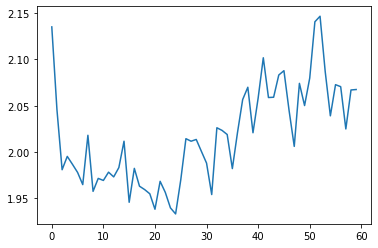

fin
Accuracy of plane : 35 %
Accuracy of car : 36 %
Accuracy of bird :  0 %
Accuracy of cat :  0 %
Accuracy of deer :  0 %
Accuracy of dog : 45 %
Accuracy of frog : 58 %
Accuracy of horse : 22 %
Accuracy of ship : 37 %
Accuracy of truck :  8 %

Total accuracy AVG: 24.54
max=58.7; min=0.1
19 [20, 30, 0, 3, 3, 0, 120, 0, 0, True, 'relu', 24.54, 58.7, 0.1, 4, 4, 2, 10, 0.005]


In [137]:
net = SimpleConvNet_my3(20, 30, 40, 50, 3, 3, 3, 3, 120, 0.1, True, F.relu)
net.to(device)
net.train(num_epochs=10, learning_rate=5e-3)
net.validatee()

In [138]:
import IPython
IPython.display.Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg", autoplay=True)
# from js2py import eval_js
# eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')


In [ ]:
ОГО! Отличный результат в 72%, думаю на нем стоит остановиться.

Итог увеличение конволюшен слоев дало хороший результат. В связке с дропаутом и 2 слоями fc получилось за 3 дня работы получить 72 %!

Кошкарев Алексей 20223